In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
import folium
from folium.plugins import MarkerCluster

In [2]:
# Load the entire training dataset
train_df = pd.read_csv('new-york-city-taxi-fare-prediction/train.csv', nrows=100000)

# Display the first few rows of the dataset
train_df.head()

# Check for missing values
train_df.isnull().sum()

# Basic statistics summary
train_df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [3]:
# Drop rows with missing values
train_df.dropna(inplace=True)

# Filter rows with invalid latitude and longitude
train_df = train_df[
    (train_df['pickup_latitude'].between(-90, 90)) &
    (train_df['pickup_longitude'].between(-180, 180)) &
    (train_df['dropoff_latitude'].between(-90, 90)) &
    (train_df['dropoff_longitude'].between(-180, 180))
]

# Extract date and time features from `pickup_datetime`
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], errors='coerce')
train_df['hour'] = train_df['pickup_datetime'].dt.hour
train_df['day_of_week'] = train_df['pickup_datetime'].dt.dayofweek
train_df['month'] = train_df['pickup_datetime'].dt.month


In [4]:
# Define bounds for valid latitude and longitude
min_latitude = 40.30
max_latitude = 45.1
min_longitude = -79.46
max_longitude = -71.51

# Print the size before filtering
print("Size before:", len(train_df))

# Filter the dataset to keep only valid coordinates
train_df = train_df[
    (train_df['pickup_latitude'] >= min_latitude) & (train_df['pickup_latitude'] <= max_latitude) &
    (train_df['pickup_longitude'] >= min_longitude) & (train_df['pickup_longitude'] <= max_longitude) &
    (train_df['dropoff_latitude'] >= min_latitude) & (train_df['dropoff_latitude'] <= max_latitude) &
    (train_df['dropoff_longitude'] >= min_longitude) & (train_df['dropoff_longitude'] <= max_longitude)
]

# Print the size after filtering
print("Size after:", len(train_df))


Size before: 99997
Size after: 97891


In [5]:
# Custom Haversine distance calculation function
def haversine_distance(row):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1 = row['pickup_latitude'], row['pickup_longitude']
    lat2, lon2 = row['dropoff_latitude'], row['dropoff_longitude']
   
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
   
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
   
    distance = R * c  # Distance in kilometers
    return distance

# Calculate distance and add it to the dataframe
train_df['distance'] = train_df.apply(haversine_distance, axis=1)

# Remove unrealistic fares and distances
train_df = train_df[(train_df['fare_amount'] > 2) & (train_df['distance'] > 0)]

# Geographical Clustering: Use K-means clustering for pickup and drop-off locations
kmeans = KMeans(n_clusters=20, random_state=42)
train_df['pickup_cluster'] = kmeans.fit_predict(train_df[['pickup_latitude', 'pickup_longitude']])
train_df['dropoff_cluster'] = kmeans.fit_predict(train_df[['dropoff_latitude', 'dropoff_longitude']])


No data available for clustering within the defined NYC bounds.


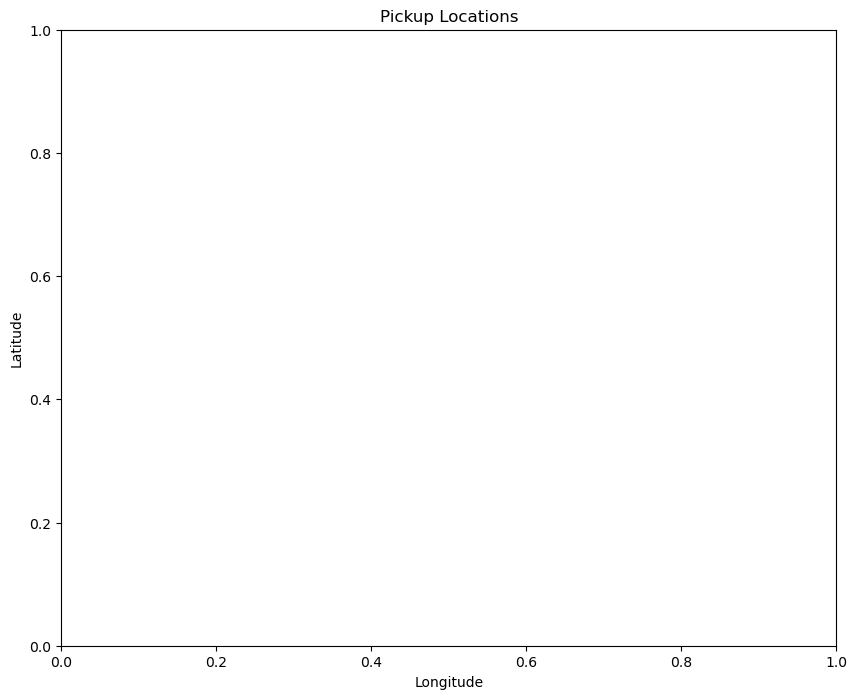

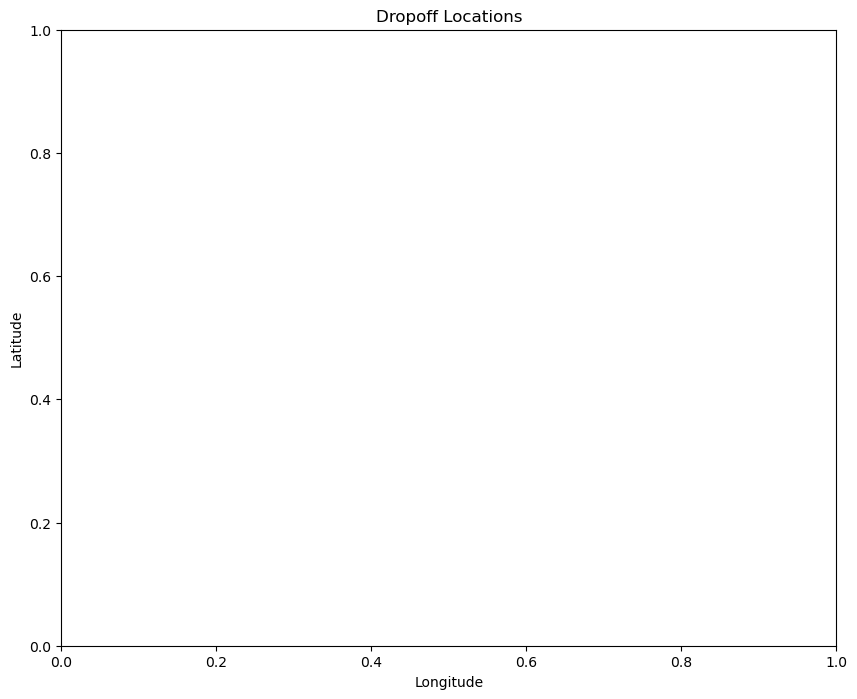

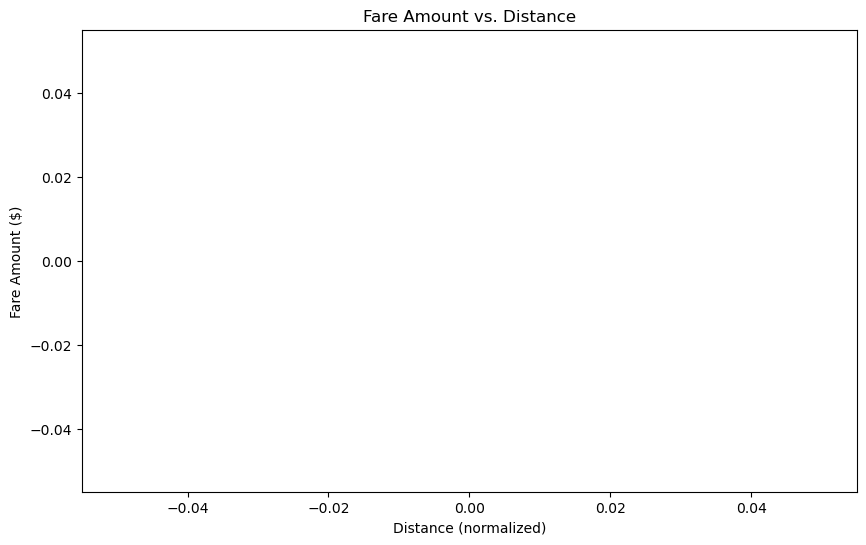

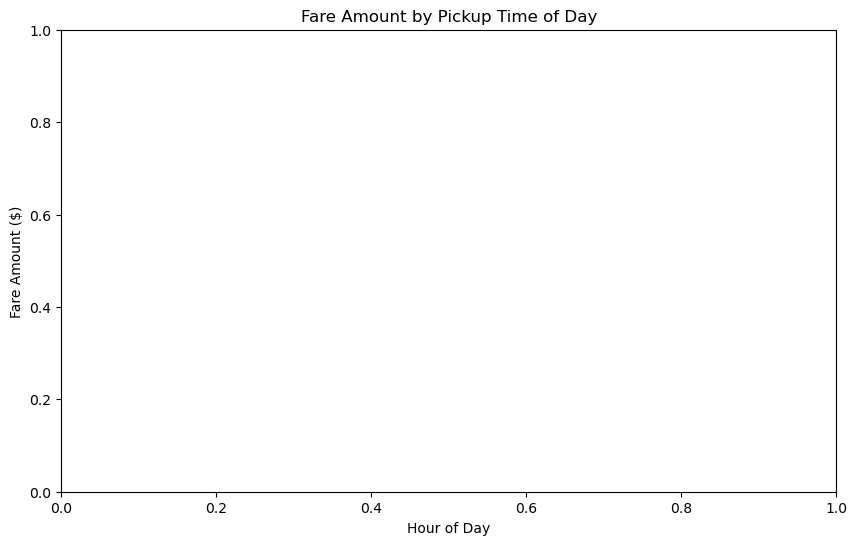

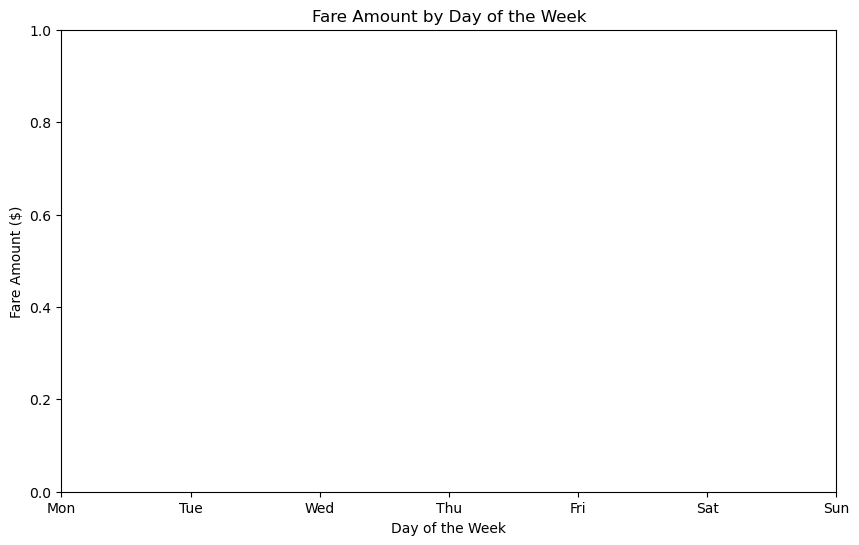

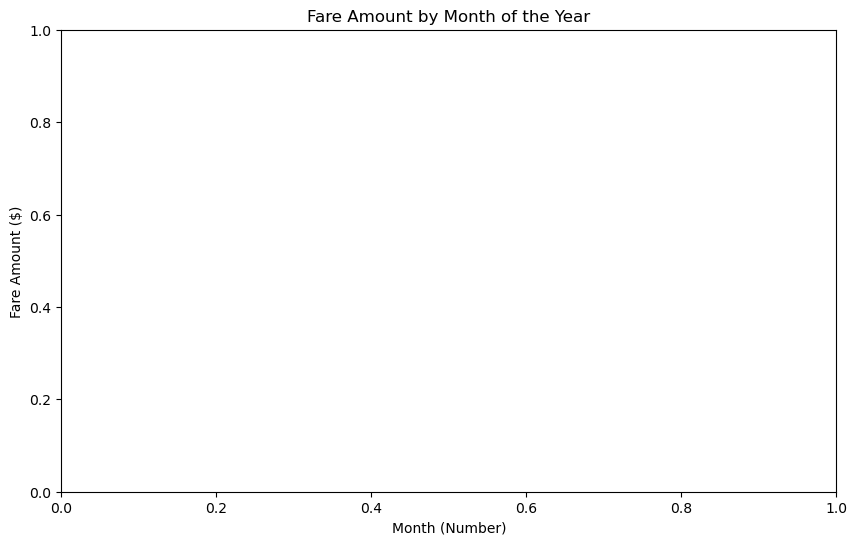

In [30]:
# Filter data based on fare amount (<= 100)
filtered_train_df = train_df[train_df['fare_amount'] <= 100]
nyc_bounds = (
    (train_df['pickup_longitude'] >= -75) & (train_df['pickup_longitude'] <= -73) &
    (train_df['pickup_latitude'] >= 39) & (train_df['pickup_latitude'] <= 41) &
    (train_df['dropoff_longitude'] >= -75) & (train_df['dropoff_longitude'] <= -73) &
    (train_df['dropoff_latitude'] >= 39) & (train_df['dropoff_latitude'] <= 41)
)

filtered_train_df = train_df[nyc_bounds].copy()

# Ensure non-empty dataframe
if filtered_train_df.empty:
    print("No data available for clustering within the defined NYC bounds.")
else:
    # Clustering using raw coordinates
    coords = filtered_train_df[['pickup_latitude', 'pickup_longitude']].values
    kmeans = KMeans(n_clusters=10, random_state=0).fit(coords)
    filtered_train_df['cluster'] = kmeans.labels_

    # Plot clusters on an interactive map
    m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'darkblue', 'darkgreen', 'cadetblue']
    for cluster_id in range(10):
        cluster_points = filtered_train_df[filtered_train_df['cluster'] == cluster_id]
        for _, row in cluster_points.iterrows():
            folium.CircleMarker(
                location=[row['pickup_latitude'], row['pickup_longitude']],
                radius=2,
                color=colors[cluster_id % len(colors)],
                fill=True,
                fill_opacity=0.5
            ).add_to(m)

    # Display the map
    m

# A. Geospatial Analysis - Plot pickup and drop-off locations to observe hotspots
# Normalize numerical features
scaler = StandardScaler()
train_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']] = scaler.fit_transform(
    train_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']])

# Plot pickup locations
plt.figure(figsize=(10, 8))
sns.scatterplot(x=filtered_train_df['pickup_longitude'], y=filtered_train_df['pickup_latitude'], s=1, alpha=0.5)
plt.title("Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Plot dropoff locations
plt.figure(figsize=(10, 8))
sns.scatterplot(x=filtered_train_df['dropoff_longitude'], y=filtered_train_df['dropoff_latitude'], s=1, alpha=0.5)
plt.title("Dropoff Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# B. Plot Relationships with Fare Amount

# Fare amount vs. Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance', y='fare_amount', data=filtered_train_df, alpha=0.5)
plt.title("Fare Amount vs. Distance")
plt.xlabel("Distance (normalized)")
plt.ylabel("Fare Amount ($)")
plt.show()

# Fare amount vs. Pickup Time of Day
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y='fare_amount', data=filtered_train_df)
plt.title("Fare Amount by Pickup Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fare Amount ($)")
plt.show()

# Fare amount vs. Day of the Week
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='fare_amount', data=filtered_train_df)
plt.title("Fare Amount by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Fare Amount ($)")
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Fare amount vs. Month of the Year (numbered)
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='fare_amount', data=filtered_train_df)
plt.title("Fare Amount by Month of the Year")
plt.xlabel("Month (Number)")
plt.ylabel("Fare Amount ($)")
plt.show()


In [7]:
# Create a table with average fare for each hour of the day
hourly_avg_fare = filtered_train_df.groupby('hour')['fare_amount'].mean().reset_index()
hourly_avg_fare.columns = ['Hour', 'Average Fare ($)']
print("Average Fare by Hour of Day:")
print(hourly_avg_fare)

# Create a table with average fare for each month
monthly_avg_fare = filtered_train_df.groupby('month')['fare_amount'].mean().reset_index()
monthly_avg_fare.columns = ['Month', 'Average Fare ($)']
print("\nAverage Fare by Month:")
print(monthly_avg_fare)

# Create a table with average fare for each week of the year
weekly_avg_fare = filtered_train_df.groupby('day_of_week')['fare_amount'].mean().reset_index()
weekly_avg_fare.columns = ['Week', 'Average Fare ($)']
print("\nAverage Fare by Week:")
print(weekly_avg_fare)


Average Fare by Hour of Day:
    Hour  Average Fare ($)
0      0         11.677185
1      1         11.514704
2      2         11.227225
3      3         11.741837
4      4         13.566399
5      5         14.607670
6      6         12.170176
7      7         11.136575
8      8         10.762382
9      9         10.719337
10    10         10.810497
11    11         11.092496
12    12         11.136251
13    13         11.594994
14    14         11.994561
15    15         12.004035
16    16         12.015823
17    17         11.334612
18    18         10.830983
19    19         10.678710
20    20         10.757290
21    21         11.025359
22    22         11.018589
23    23         11.530493

Average Fare by Month:
    Month  Average Fare ($)
0       1         10.750838
1       2         10.843893
2       3         11.134073
3       4         11.287328
4       5         11.512634
5       6         11.512774
6       7         10.983085
7       8         11.178737
8       9         11

In [8]:
# Split the data into train and test
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare features and target for the train data
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'hour', 'day_of_week', 'distance', 'pickup_cluster', 'dropoff_cluster']
X_train = train_df[features]
y_train = train_df['fare_amount']

# Prepare features for the test data (no target in test)
X_test = test_df[features]
y_test = test_df['fare_amount']

# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

# Define callbacks for early stopping and learning rate scheduling
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=256,
    callbacks=[early_stopping, lr_scheduler]
)


C:\Users\billy\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.0227 - mae: 5.0227 - val_loss: 2.3516 - val_mae: 2.3516 - learning_rate: 0.0010
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3093 - mae: 2.3093 - val_loss: 2.1987 - val_mae: 2.1987 - learning_rate: 0.0010
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2148 - mae: 2.2148 - val_loss: 2.1286 - val_mae: 2.1286 - learning_rate: 0.0010
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1774 - mae: 2.1774 - val_loss: 2.0656 - val_mae: 2.0656 - learning_rate: 0.0010
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1150 - mae: 2.1150 - val_loss: 2.1155 - val_mae: 2.1155 - learning_rate: 0.0010
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0406 - mae: 2.0406 - val_loss: 2.0400 - val_mae: 2.0400 - learning_rate: 0.0010
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0317 - mae: 2.0317 - val_loss: 2.0119 - val_mae: 2.0119 - learning_rate: 0.0010
Epoch 

606/606 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Mean Absolute Error: 2.0101506437382017
Test Mean Squared Error: 19.098573149385775
Test Root Mean Squared Error: 4.370191431663581


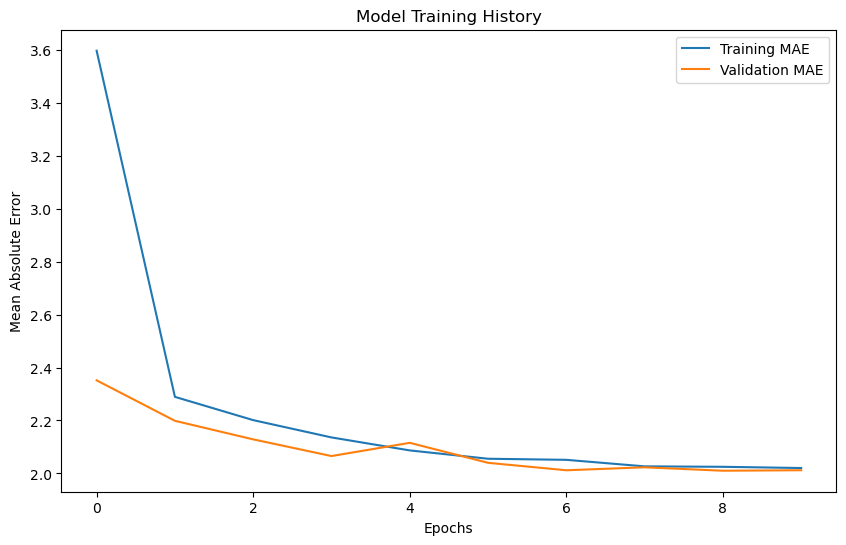

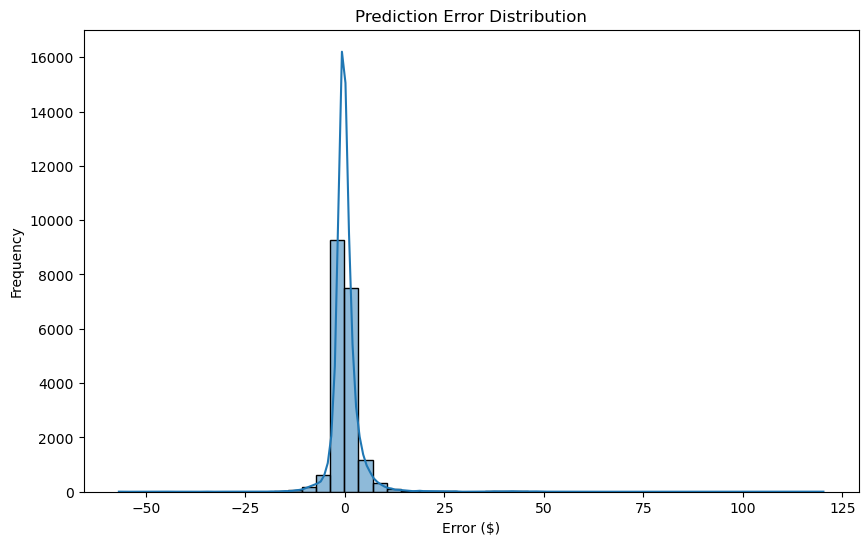

In [9]:
# Evaluate on the test data
test_predictions = model.predict(X_test)

# Calculate the evaluation metrics on test data
mae_test = mean_absolute_error(y_test, test_predictions)
mse_test = mean_squared_error(y_test, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f"Test Mean Absolute Error: {mae_test}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test Root Mean Squared Error: {rmse_test}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("Model Training History")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

# Visualize the prediction errors
plt.figure(figsize=(10, 6))
sns.histplot(y_test - test_predictions.flatten(), bins=50, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Error ($)")
plt.ylabel("Frequency")
plt.show()
